## Pacotes

In [59]:
import string
import io
import matplotlib.pyplot as plt
import base64
import openpyxl
import re
import unicodedata
import nltk
import boto3
from boto.s3.connection import S3Connection
import ssl
from botocore.exceptions import NoCredentialsError
from collections import Counter
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

## Stopwords

In [10]:
# Fazendo o download das stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thais\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thais\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
# Lista de stopwords em português e inglês
stop_words_pt = set(nltk.corpus.stopwords.words('portuguese'))
stop_words_en = set(nltk.corpus.stopwords.words('english'))

## Funções

In [60]:
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,
                                  password=password,
                                  caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)

    fp.close()
    device.close()
    text = retstr.getvalue()
    retstr.close()
    return text


def remove_pontuacao(text):
    # Remove acentos e caracteres especiais
    texto_sem_acentos = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    
    # Remove pontuações
    texto_puro = re.sub(r'[^\w\s]', '', texto_sem_acentos).lower()
    
    return texto_puro


def mapa(text):
    texto = remove_pontuacao(text)
    palavras = texto.split()
    numero_palavras = Counter(palavras)
    return numero_palavras


def reduce(palavras):
    dic = {}
    
    for p in palavras:
        if(p in stop_words_pt or p in stop_words_en or p == "nao" or p == "sao" or p == "pode" or p == "cada" or p == " " or p == "" or p == "-" or len(p) in [1, 2]): 
                continue
        dic[p] = palavras[p]
    
    return dic    


def grava_imagem(mapa):
    mapaPlot = {}
    cont = 0
    for i in sorted(mapa, key=mapa.get, reverse=True):
        if(cont > 20):
            break;
        
        cont += 1
        mapaPlot[i] = mapa[i]
        
    plt.barh(list(mapaPlot.keys()), mapaPlot.values())
    plt.gca().invert_yaxis()
    plt.savefig('FrequenciaPalavras_ThaisMachado.png', format='png')
    plt.show()  
    plt.close()   
    
    
def grava_planilha_xlsx(dict, n, file_name):
    
    mapa = {}
    cont = 1
    for i in sorted(dict, key=dict.get, reverse=True):
        if(cont > n):
            break;
        cont += 1
        mapa[i] = dict[i]
        
    # Cria um novo arquivo Excel
    workbook = openpyxl.Workbook()
    
    # Seleciona a primeira planilha
    sheet = workbook.active
    
    # Adiciona cabeçalhos
    sheet["A1"] = "Palavra"
    sheet["B1"] = "Frequência"
    
    # Preenche a planilha com os dados do dicionário
    row = 2
    for palavra, frequencia in mapa.items():
        sheet[f"A{row}"] = palavra
        sheet[f"B{row}"] = frequencia
        row += 1
    
    # Salva o arquivo
    workbook.save(file_name)

In [28]:
palavras = convert_pdf_to_txt("ciencia_dados.pdf")

In [61]:
mapa = mapa(palavras)

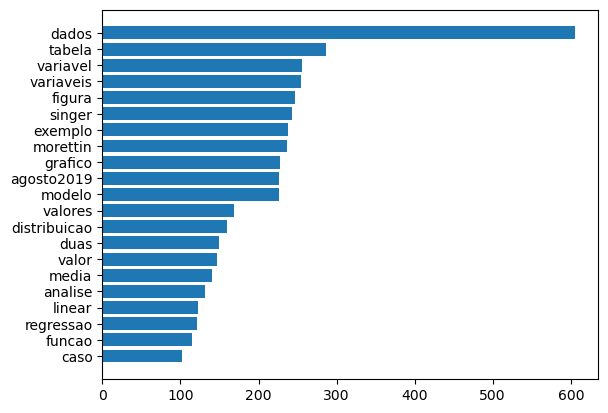

In [62]:
resultado = reduce(mapa)
grava_imagem(resultado)

In [43]:
grava_planilha_xlsx(resultado, 30, "FrequenciaPalavras_ThaisMachado.xlsx")

In [48]:
ACCESS_KEY = 'ACCESS_KEY'
SECRET_KEY = 'SECRET_KEY'
BUCKET_NAME = 'datalake-turma5.1'
FILE_NAME = 'metadados/FrequenciaPalavras_ThaisMachado.xlsx'

In [46]:
s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)

In [55]:
try:
    # Enviar arquivo para o bucket
    with open("FrequenciaPalavras_ThaisMachado.xlsx", 'rb') as data:
        s3.put_object(Bucket=BUCKET_NAME, Key=FILE_NAME, Body=data)
    print("Arquivo enviado com sucesso para o bucket da AWS!")
except FileNotFoundError:
    print("O arquivo não foi encontrado.")
except NoCredentialsError:
    print("Credenciais não encontradas.")

Arquivo enviado com sucesso para o bucket da AWS!


In [56]:
ssl._create_default_https_context = ssl._create_unverified_context
conn = S3Connection('ACCESS_KEY', 'SECRET_KEY')
bucket = conn.get_bucket('datalake-turma5.1')

for key in bucket.list():
    print(key.name.encode('utf-8'))

b'Json/'
b'Json/Edmilson/Jogos Flamengo - Edmilson.json'
b'Json/Flamengo_Jogos_Lucas_Furtado.json'
b'Json/Igor_Moreira/Bragantino_jogos_IgorMoreira.json'
b'Json/Jogos Atletico MG Pamela.Json'
b'Json/Jogos Atletico Mineiro Pamela.Json'
b'Json/Jogos Brasileiro Matheus Maquine.Json'
b'Json/Jogos Brasileiro Nelson.Json'
b'Json/Jogos Cruzeiro Clara.Json'
b'Json/Jogos_Brasileiro_Cruzeiro_JoaoPaulo.json'
b'Json/Mauricio_Bortoleto.json'
b'Json/Raphael/Jogos brasileiro Raphael.json'
b'Json/Sandra/Cruzeiro_jogos_Sandra.json'
b'Json/Thais_Oliveira/Palmeiras_jogos_Thais.json'
b'Json/Tha\xc3\xads_Oliveira/Palmeiras_jogos_Tha\xc3\xads.json'
b'Json/botafogoRJ_lucas_jose.json'
b'Json/hyagomesquita/jogos_vencidos_sao_paulo.json'
b'Json/lesley_dias/lesley_dias.json'
b'Planilhas/Flamengo_Jogos_Lucas_Furtado.xlsx'
b'Planilhas/Igor_Moreira/Bragantino_jogos_IgorMoreira.xlsx'
b'Planilhas/Mauricio_Bortoleto.xlsx'
b'Planilhas/Sandra/Cruzeiro_jogos_Sandra.xlsx'
b'Planilhas/Thais_Oliveira/Palmeiras_jogos_Thais.x